In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
%pip install xgboost

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [3]:
#Load the data
df = pd.read_csv(r"nivea_dataset.csv", delimiter = ',', quotechar='"')
df.drop(df.columns[0],axis=1,inplace=True)

print(f"Dataset shape : {df.shape}")

Dataset shape : (9289, 5)


In [4]:
df.head()

,product_name,review_title,review_date,review_stars,review_text
0,"NIVEA MEN Face & Beard Wash Cleanser, DEEP Act...",Good Product,Reviewed in the United Arab Emirates on 2 May ...,5,I am a regular user of this face and beard was...
1,"NIVEA MEN Face & Beard Wash Cleanser, DEEP Act...",Nice product,Reviewed in the United Arab Emirates on 8 Dece...,5,Good
2,"NIVEA MEN Face & Beard Wash Cleanser, DEEP Act...",DEEP face & beard wash,Reviewed in the United Arab Emirates on 10 Aug...,4,Received the Nivea Men DEEP Face & Beard wash ...
3,"NIVEA MEN Face & Beard Wash Cleanser, DEEP Act...",Good,Reviewed in the United Arab Emirates on 7 Marc...,5,"I like the item, it makes your face fresh."
4,"NIVEA MEN Face & Beard Wash Cleanser, DEEP Act...",ok,Reviewed in the United Arab Emirates on 6 Sept...,3,ok


In [5]:
#Check for null values

df.isnull().sum()

product_name    0
review_title    0
review_date     0
review_stars    0
review_text     0
dtype: int64

In [6]:
df[df['review_title'].isna() == True]

,product_name,review_title,review_date,review_stars,review_text


In [7]:
df.dropna(inplace=True)
print(f"Dataset shape after dropping null values : {df.shape}")

Dataset shape after dropping null values : (9289, 5)


In [8]:
df['length'] = df['review_text'].apply(len)
df.head()

,product_name,review_title,review_date,review_stars,review_text,length
0,"NIVEA MEN Face & Beard Wash Cleanser, DEEP Act...",Good Product,Reviewed in the United Arab Emirates on 2 May ...,5,I am a regular user of this face and beard was...,158
1,"NIVEA MEN Face & Beard Wash Cleanser, DEEP Act...",Nice product,Reviewed in the United Arab Emirates on 8 Dece...,5,Good,4
2,"NIVEA MEN Face & Beard Wash Cleanser, DEEP Act...",DEEP face & beard wash,Reviewed in the United Arab Emirates on 10 Aug...,4,Received the Nivea Men DEEP Face & Beard wash ...,465
3,"NIVEA MEN Face & Beard Wash Cleanser, DEEP Act...",Good,Reviewed in the United Arab Emirates on 7 Marc...,5,"I like the item, it makes your face fresh.",42
4,"NIVEA MEN Face & Beard Wash Cleanser, DEEP Act...",ok,Reviewed in the United Arab Emirates on 6 Sept...,3,ok,2


In [9]:
print(f"Rating value count: \n{df['review_stars'].value_counts()}")

Rating value count: 
5    6335
4    1582
3     623
1     511
2     238
Name: review_stars, dtype: int64


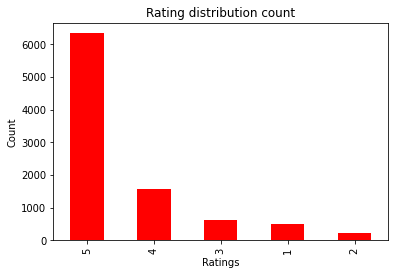

In [10]:
#Bar plot to visualize the total counts of each rating

df['review_stars'].value_counts().plot.bar(color = 'red')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

C:\Users\hp\anaconda3\envs\gputest\lib\site-packages\pandas\plotting\_matplotlib\core.py:1547: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


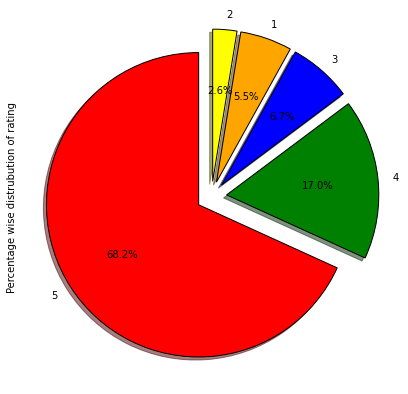

In [11]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green', 'blue','orange','yellow')

wp = {'linewidth':1, "edgecolor":'black'}

tags = df['review_stars'].value_counts()/df.shape[0]

explode = ()
for i in tags:
    explode+=(0.1,)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')

from io import  BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")

In [12]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [13]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()

In [14]:
# Calculating sentiment scores
df['sentiment_score'] = df['review_text'].apply(lambda review: vader.polarity_scores(review)['compound'])

# Custom function to assign sentiment categories
def assign_sentiment(score):
    if score > 0:
        return 1   # Positive
    elif score < 0:
        return -1  # Negative
    else:
        return 0   # Neutral

# Applying the custom function to the sentiment scores
df['sentiment_category'] = df['sentiment_score'].apply(assign_sentiment)
df

,product_name,review_title,review_date,review_stars,review_text,length,sentiment_score,sentiment_category
0,"NIVEA MEN Face & Beard Wash Cleanser, DEEP Act...",Good Product,Reviewed in the United Arab Emirates on 2 May ...,5,I am a regular user of this face and beard was...,158,0.7845,1
1,"NIVEA MEN Face & Beard Wash Cleanser, DEEP Act...",Nice product,Reviewed in the United Arab Emirates on 8 Dece...,5,Good,4,0.4404,1
2,"NIVEA MEN Face & Beard Wash Cleanser, DEEP Act...",DEEP face & beard wash,Reviewed in the United Arab Emirates on 10 Aug...,4,Received the Nivea Men DEEP Face & Beard wash ...,465,0.9659,1
3,"NIVEA MEN Face & Beard Wash Cleanser, DEEP Act...",Good,Reviewed in the United Arab Emirates on 7 Marc...,5,"I like the item, it makes your face fresh.",42,0.5859,1
4,"NIVEA MEN Face & Beard Wash Cleanser, DEEP Act...",ok,Reviewed in the United Arab Emirates on 6 Sept...,3,ok,2,0.2960,1
...,...,...,...,...,...,...,...,...
9284,"NIVEA Face Cream Day Moisturizer, Q10 Plus C A...",Good,Reviewed in the United Arab Emirates on 29 Oct...,5,I like,6,0.3612,1
9285,"NIVEA Face Under-Eye Mask Hydrating, Rose Care...",I like it,Reviewed in the United Arab Emirates on 31 Mar...,5,I like it,9,0.3612,1
9286,"NIVEA Face Under-Eye Mask Hydrating, Rose Care...",great value for money,Reviewed in the United Arab Emirates on 11 Feb...,5,great in the morning!,21,0.6588,1
9287,Nivea Micellar Expert Waterproof Face Cleansin...,Amazing Product..,Reviewed in the United Arab Emirates on 23 Jan...,5,It's Really A Unique Product With Bio Green Te...,154,0.8173,1


In [15]:
df['length'].describe()

count    9289.000000
mean      127.280332
std       140.945097
min         1.000000
25%        20.000000
50%        80.000000
75%       190.000000
max      1144.000000
Name: length, dtype: float64

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

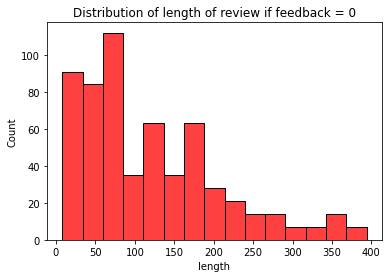

In [16]:
sns.histplot(df[df['sentiment_category']==-1]['length'],color='red').set(title='Distribution of length of review if feedback = 0')

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

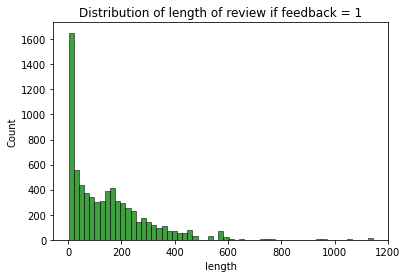

In [17]:
sns.histplot(df[df['sentiment_category']==1]['length'],color='green').set(title='Distribution of length of review if feedback = 1')

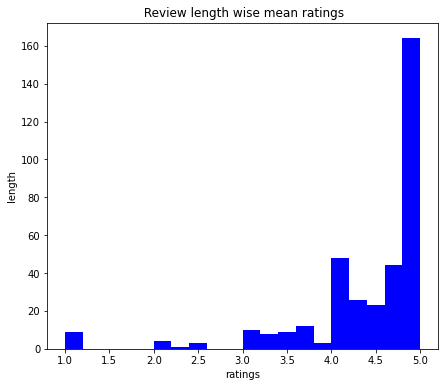

In [18]:
df.groupby('length')['review_stars'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [19]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(df.review_text)

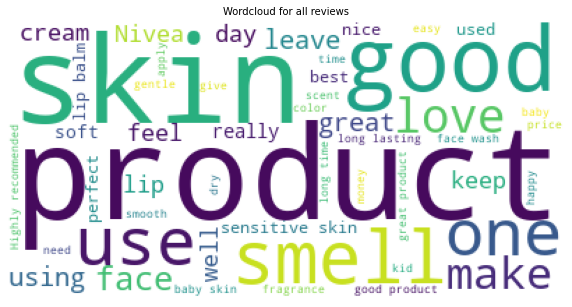

In [20]:
# Combine all reviews
reviews = " ".join([review for review in df['review_text']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

In [21]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in df[df['sentiment_category']==-1]['review_text']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in df[df['sentiment_category']==1]['review_text']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

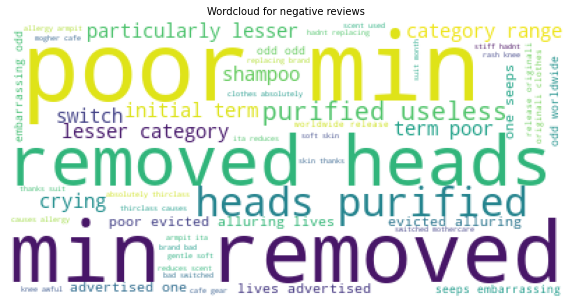

In [22]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

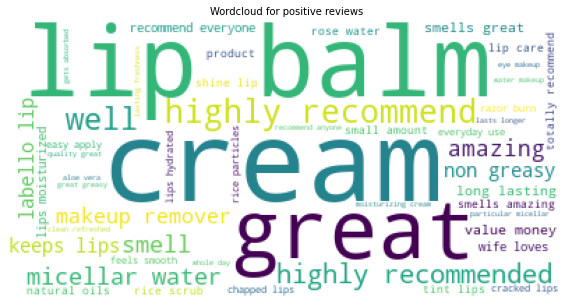

In [23]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

In [24]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, df.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', df.iloc[i]['review_text'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

In [25]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = df['sentiment_category'].values

In [26]:
pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

In [27]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (9289, 1748)
y shape: (9289,)


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (6502, 1748)
y train: (6502,)
X test: (2787, 1748)
y test: (2787,)


In [29]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 7
X test max value: 7


In [30]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [31]:
#Saving the scaler model
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))

In [32]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [33]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9987696093509689
Testing Accuracy : 0.9978471474703983


In [34]:
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)

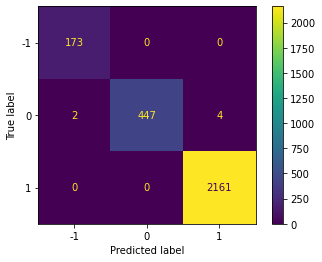

In [35]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

In [36]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9984622474299896
Standard Variance : 0.001375514129258394


In [37]:
from sklearn import datasets
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics

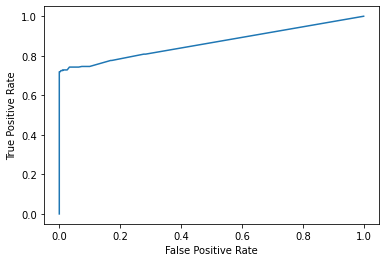

In [38]:
#define metrics
y_pred_proba = model_rf.predict_proba(X_test)[::,1]
tpr, fpr, _ = metrics.roc_curve(y_test,  y_pred_proba, pos_label=1)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [39]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [58]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [41]:
print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 8, 'n_estimators': 300}


In [42]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 99.49054137188557
Cross validation mean accuracy on test set : 97.76414949246386
Accuracy score for test set : 0.9978471474703983


In [43]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train+1)

C:\Users\hp\anaconda3\envs\gputest\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:10:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [44]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_xgb.score(X_train_scl, y_train+1))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test+1))

Training Accuracy : 0.996001230390649
Testing Accuracy : 0.9917473986365267


In [45]:
y_preds = model_xgb.predict(X_test)

In [46]:
#Confusion Matrix
cm = confusion_matrix(y_test+1, y_preds)
print(cm)

[[ 163    5    5]
 [   0  447    6]
 [   0    7 2154]]


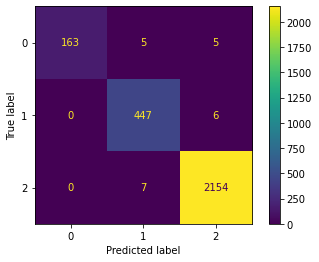

In [47]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [48]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open('Models/model_xgb.pkl', 'wb'))

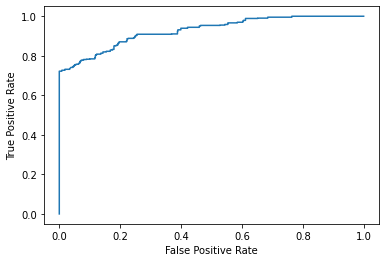

In [49]:
#define metrics
y_pred_proba = model_xgb.predict_proba(X_test)[::,1]
tpr, fpr, _ = metrics.roc_curve(y_test,  y_pred_proba, pos_label=1)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [50]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [51]:
#Accuracy of the model on training and testing data
print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

Training Accuracy : 0.9987696093509689
Testing Accuracy : 0.9978471474703983


In [52]:
y_preds = model_dt.predict(X_test)

In [53]:
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 171    0    2]
 [   4  433   16]
 [  57    0 2104]]


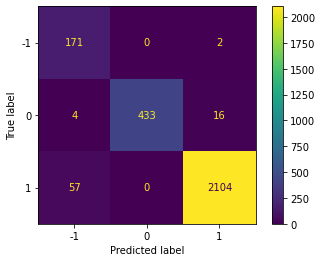

In [54]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()

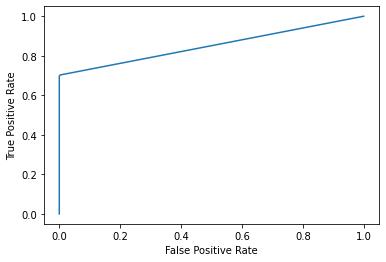

In [55]:
#define metrics
y_pred_proba = model_dt.predict_proba(X_test)[::,1]
tpr, fpr, _ = metrics.roc_curve(y_test,  y_pred_proba, pos_label=1)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Accuracy: 0.9863652673125224
Precision: 0.9865372624800953
Recall: 0.9863652673125224
F1 Score: 0.9860184147492005


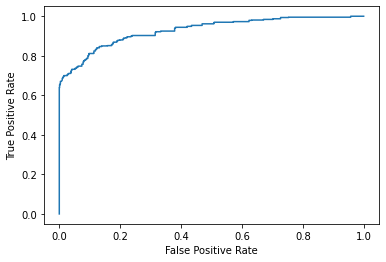

In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


log_reg = LogisticRegression()

log_reg.fit(X_train_scl, y_train)

y_pred = log_reg.predict(X_test_scl)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, y_pred, average='weighted')
print("Precision:", precision)

recall = recall_score(y_test, y_pred, average='weighted')
print("Recall:", recall)

f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

# Plot ROC curve
y_score = log_reg.predict_proba(X_test_scl)

fpr = dict()
tpr = dict()
roc_auc = dict()

#define metrics
y_pred_proba = log_reg.predict_proba(X_test)[::,1]
tpr, fpr, _ = metrics.roc_curve(y_test,  y_pred_proba, pos_label=1)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



In [60]:
# Import required metrics functions
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to evaluate model performance
def evaluate_model_performance(model, X_test, y_test):
    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print evaluation results
    print(f"Model: {model.__class__.__name__}")
    print(f"Accuracy: {accuracy:}")
    print(f"Precision: {precision:}")
    print(f"Recall: {recall:}")
    print(f"F1 Score: {f1:}")
    print("-" * 30)

# Evaluate Decision Tree model
evaluate_model_performance(model_dt, X_test_scl, y_test)

# Evaluate Random Forest model
evaluate_model_performance(model_rf, X_test_scl, y_test)

# Evaluate XGBoost model
evaluate_model_performance(model_xgb, X_test_scl, y_test +1)


Model: DecisionTreeClassifier
Accuracy: 0.9978471474703983
Precision: 0.9978580005177925
Recall: 0.9978471474703983
F1 Score: 0.997842696953656
------------------------------
Model: RandomForestClassifier
Accuracy: 0.9978471474703983
Precision: 0.9978580005177925
Recall: 0.9978471474703983
F1 Score: 0.997842696953656
------------------------------
Model: XGBClassifier
Accuracy: 0.9917473986365267
Precision: 0.991810974549958
Recall: 0.9917473986365267
F1 Score: 0.9917182356576313
------------------------------
